### <font color = 'blue'> Hongchi Zhang

# MTH9875 Homework 10

Assigned: November 3, 2016.
Due: November 17, 2016 by 6pm. 

Late homework **will not be accepted**.

<font color = "red">Homework is to be done by each student individually.  To receive full credit, you must email a completed copy of this iPython notebook to Victor Istratov (stavka@gmail.com), Yassine Ghalem (yassine.ghalem@gmail.com) and Jim Gatheral (jim.gatheral@gmail.com) by the due date and time.  All R-code must run correctly and solutions must be written up neatly in Markdown/LaTeX format.

### 0. (0 points)

Read Chapters 9 and 10 of The Volatility Surface

## Comparing stochastic and local volatility pricing of lookback options

$$
\newcommand{\supp}{\mathrm{supp}}
\newcommand{\E}{\mathbb{E} }
\def\Cov{{ \mbox{Cov} }}
\def\Var{{ \mbox{Var} }}
\newcommand{\1}{\mathbf{1} }
\newcommand{\PP}{\mathbb{P} }
%\newcommand{\Pr}{\mathrm{Pr} }
\newcommand{\QQ}{\mathbb{Q} }
\newcommand{\RR}{\mathbb{R} }
\newcommand{\DD}{\mathbb{D} }
\newcommand{\HH}{\mathbb{H} }
\newcommand{\spn}{\mathrm{span} }
\newcommand{\cov}{\mathrm{cov} }
\newcommand{\sgn}{\mathrm{sgn} }
\newcommand{\HS}{\mathcal{L}_{\mathrm{HS}} }
%\newcommand{\HS}{\mathrm{HS} }
\newcommand{\trace}{\mathrm{trace} }
\newcommand{\LL}{\mathcal{L} }
%\newcommand{\LL}{\mathrm{L} }
\newcommand{\s}{\mathcal{S} }
\newcommand{\ee}{\mathcal{E} }
\newcommand{\ff}{\mathcal{F} }
\newcommand{\hh}{\mathcal{H} }
\newcommand{\bb}{\mathcal{B} }
\newcommand{\dd}{\mathcal{D} }
\newcommand{\g}{\mathcal{G} }
\newcommand{\p}{\partial}
\newcommand{\half}{\frac{1}{2} }
\newcommand{\T}{\mathcal{T} }
\newcommand{\bi}{\begin{itemize}}
\newcommand{\ei}{\end{itemize}}
\newcommand{\beq}{\begin{equation}}
\newcommand{\eeq}{\end{equation}}
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
\newcommand{\cO}{\mathcal{O}}
\newcommand{\cF}{\mathcal{F}}
\newcommand{\cL}{\mathcal{L}}
$$



In the following, a lookback call is defined to pay

$$
\left(S_{\text{max}}-K\right)^+
$$
where $S_{\text{max}}$ is the maximum and $K$ is the strike price.

### 1. (8 points)

Use (for example) the stochastic volatility and local volatility Monte Carlo codes (`HestonMCxmax` and `HestonLvMCxmax` respectively) from Lecture 11 to price a one year at-the-money lookback call
that is monitored once a day (assume 252 working days in a year).

Use the usual HN parameters  - namely:

$$
\begin{eqnarray*}
v&=& 0.04\\ \bar v &=& 0.04\\ \lambda&=&10\\ \eta&=&1\\\rho&=&-1.
\end{eqnarray*}
$$

Use 252 time steps and 20,000 paths.  Do not use Richardson extrapolation.

In [1]:
paramsHN <- list(lambda = 10,rho = -1,eta = 1,vbar = 0.04,v = 0.04)

In [2]:
evolveAlfonsiF <- function(v,x,dt,W1,W2,L){
  
  eldt2 <- exp(-lambda*dt/2);
  
  #Variance process 
  vbarp <- vbar - eta^2/(4*lambda);
  psi <- (1-eldt2)/lambda;
  v1 <- v*eldt2+lambda*vbarp*psi;
  v2 <- (v1 > 0) * v1; # Take v2 = 0 if v1<0, else v2=v1
  par <- sqrt(v2) + eta/2 * sqrt(dt)*W2;
  vf <- eldt2*par*par +lambda*vbarp*psi + v1 - v2;
  # Full truncation
  
  # Log-stock process (Andersen equation (33))
  vvf <- (v+vf > 0) * (v+vf);
  dw <- vvf/2*dt;
  x <- x  - dw/2 + rho2m1*sqrt(dw)*W1 +
    rho/eta*(lambda*dw + vf-v -lambda*vbar*dt) ;
  # Impose martingale constraint
  x <- x - log(mean(exp(x)));
  v <- vf;
  return(cbind(x,v));
}

In [3]:
HestonMCxmax <- function(params){

  is.even <- function(j){as.logical((j+1) %% 2)}
  
  res <- function(S0, T, AK, N, m, evolve)
  {
    
    lambda <<- params$lambda 
    rho <<- params$rho 
    eta <<- params$eta 
    vbar <<- params$vbar 
    v0 <<- params$v 
    
    n <- m
    sqrt2 <- sqrt(2) 
    rho2m1 <<- sqrt(1-rho*rho) 
      
    vbarp <<- vbar - eta^2/(4*lambda) 
    
    negCount <- 0 
    
    # We use a vertical array, one element per M.C. path
    x <- numeric(N);  v <- rep(1,N)*v0  
    xmax <- x 
    #xm <- x  
    #vm <- v
    #xmaxm <- xmax 
    xmin <- numeric(N)  
    #xminm <- numeric(N) 
    W1m <- numeric(N) 
    W2m <- numeric(N)  
    
    # Loop for bias computation (N small, n big)
    for (i in 1:n)
    {
      # Two sets of correlated normal random vars.
      
      W1 <- rnorm(N) 
      W2 <- rnorm(N) 
      W1 <- W1 - mean(W1)
      W1 <- W1/sd(W1) 
      W2 <- W2 - mean(W2)
      W2 <- W2/sd(W2) 
      # Now W1 and W2 are forced to have mean=0 and sd=1
      
      W2p <- W2 - cor(W1,W2)*W1  # Eliminate actual correlation
      W2p <- W2p - mean(W2p)  
      W2 <- W2p/sd(W2p)  
      # Now W1 and W2 have mean=0, sd=1 and correlation=0
      
      L <- rbinom(N, size=1, prob=1/2)  # Bernoulli rv for NV step
     
      res <- evolve(v,x,T/n,W1,W2,L) 
      xnew <- res[,1] 
      xmax <- (xnew>xmax)*(xnew-xmax)+xmax 
      xmin <- (xnew<xmin)*(xnew-xmin)+xmin 
      
      #---------------------------------------------------------------------------------------------------------------  
      x <- xnew 
      v <- res[,2] 
      
    }
    
    return(data.frame(x,v,xmax,xmin)) 
    
  }
  return(res) 
}

In [4]:
# Monte Carlo  - Local Volatility
HestonLvMCxmax <- function(params){

  is.even <- function(j){as.logical((j+1) %% 2)}
  
  res <- function(S0, T, N, m)
  {
    
    lambda <- params$lambda;
    rho <- params$rho;
    eta <- params$eta;
    vbar <- params$vbar;
    v0 <- params$v;
    
    lambdap <- lambda+eta/2;
    vbarp <- vbar*lambda/lambdap;
    
    n <- m;
    dt <- T/n;
    dtm <- dt*2;
    
    sqrtdt <- sqrt(dt);
    sqrtdtm <- sqrt(dtm);
    sqrt2 <- sqrt(2);
    
    # We use a vertical array, one element per M.C. path
    x <- numeric(N); vloc <- rep(v0,N); 
    #xm <- numeric(N); vlocm <- rep(v0,N); 
    xmax <- numeric(N); 
    #xmaxm <- numeric(N);
    xmin <- numeric(N); 
    #xminm <- numeric(N);
    #W1m <- numeric(N);
    
    # Loop over timesteps
    for (i in 1:n)
    {
      W1 <- rnorm(N);
      W1 <- W1 - mean(W1); W1 <- W1/sd(W1);
      # Now W1 is forced to have mean=0 and sd=1  
      
      # Add code for subgrid
     # W1m <- W1m + W1/sqrt2; # N(0,1) rv's for subgrid
      
      # Compute local variance from formula 4.1 of TVS
      ti <- i*dt;
      elti <- exp(-lambdap*ti);	
      vlocf <- (v0-vbarp)*elti+vbarp-eta*x*(1-elti)/(lambdap*ti);
      vlocf <- (vlocf>=0)*vlocf;
      
      # Approximate integrated variance
      w <- (vlocf +vloc)/2*dt;
      
      xnew <- x - w/2 + sqrt(w)*W1;

      xmax <- (xnew>xmax)*(xnew-xmax)+xmax;
      xmin <- (xnew<xmin)*(xnew-xmin)+xmin;
      
      #--------------------------------------------------------------------------------------------------------------
      x <- xnew;
      vloc <- vlocf;
    }
    
    return(data.frame(x,vloc,xmax,xmin));
    
  }
  return(res);
}

In [5]:
sampleLV <- HestonLvMCxmax(paramsHN)(S0=1, T=1, N=20000, m=252);
sampleSV <- HestonMCxmax(paramsHN)(S0=1, T=1, N=20000, m=252,evolve=evolveAlfonsiF);

In [6]:
lookbackCall <- function(data,strike){

  Smax <- exp(data$xmax)
  K <- strike

  V <- (Smax>K)*(Smax-K)
  AV <- mean(V)

  return(AV)
}

In [7]:
P_lookbackC_LV = lookbackCall(sampleLV,1)
P_lookbackC_SV = lookbackCall(sampleSV,1)

print(paste('ATM lookbackCall under LV is',P_lookbackC_LV))
print(paste('ATM lookbackCall under SV is',P_lookbackC_SV))

[1] "ATM lookbackCall under LV is 0.134855706650311"
[1] "ATM lookbackCall under SV is 0.126497085793996"


### 2. (4 points) 

Plot local volatility and stochastic volatility prices of lookback options for a range of strikes from $1.0$ to $1.4$, reproducing Figure 8 of Lecture 10.

In [8]:
ks = seq(1.0,1.4,0.01)
lookback_lv_vec = sapply(ks,function(x){lookbackCall(sampleLV,x)})
lookback_sv_vec = sapply(ks,function(x){lookbackCall(sampleSV,x)})

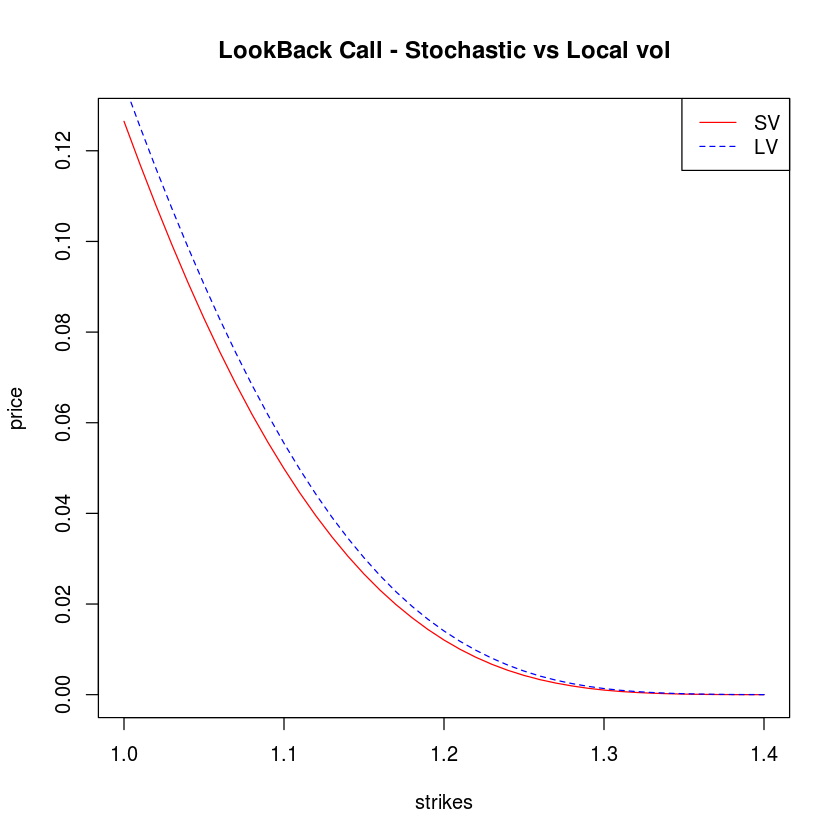

In [9]:
plot(ks,lookback_sv_vec,lty=1,type='l',col='red',
     main='LookBack Call - Stochastic vs Local vol',xlab='strikes',ylab='price',xlim=c(1.0,1.4))
lines(ks,lookback_lv_vec,col='blue',lty=2,xlim=c(1.0,1.4))
legend('topright',c('SV','LV'),col=c('red','blue'),lty=c(1,2))

### 3. (6 points) 

What is the intuition behind the difference in price under stochastic volatility and local volatility assumptions respectively?  Appeal to the dynamics of the implied volatility skew in
your answer. 

<font color = 'blue'>
In terms of forward skew, local volatility projects forward skew to be flatter than under stochastic volatility model. Since lookback calls can be hedged dynamically with two European call options. If and when the stock price reaches $K$, we need to sell our two European calls with strike $K$ and buy two new calls with strike $K + \Delta K$. So you will dynamically sell the ATM vols and buy OTM call vols. Under local vol, forward skew is flat. ATM vol and OTM call vol are roughly the same. However, in stochastic vol, forward skew is negative. Therefore, you buy the two OTM calls at cheaper vols. So everytime you re-hedge your position, you make money in stochastic vol framework over local volatility model. Since the hedging cost is reduced by the profit, therefore, the fair prices under stochastic vol model is less than local volatility model. 

<font color = 'blue'> 

A more intuitive explanation to trader:
As spot goes up, because local volatility remains high (flat vol skew, high vol on the call strikes) Therefore, more chance for the running maximum to continue to increase, thus higher price

## The effect of discreteness

### 4. (6 points) 

Repeat Problem 1 with weekly monitoring (assume 52 weeks).  Estimate the difference in price using the Broadie, Glasserman and Kou adjustment.  Compare with your Monte Carlo results and comment.

In [10]:
sampleLV_W <- HestonLvMCxmax(paramsHN)(S0=1, T=1, N=20000, m=52);
sampleSV_W <- HestonMCxmax(paramsHN)(S0=1, T=1, N=20000, m=52,evolve=evolveAlfonsiF);


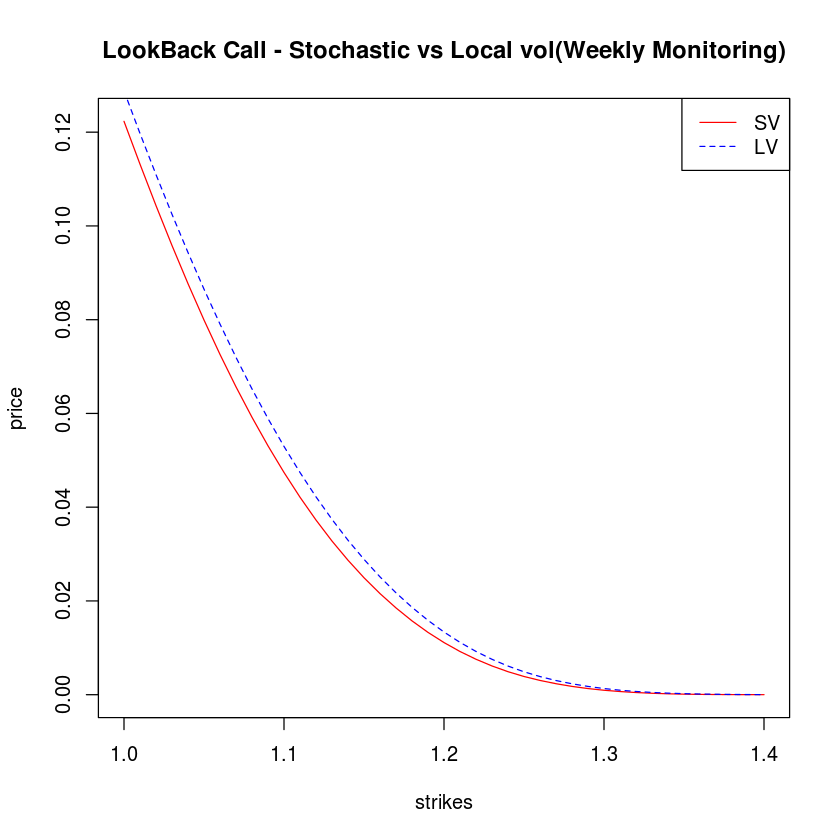

In [11]:
#Weekly Monitoring Price - Monte Carlo
ks = seq(1.0,1.4,0.01)
lookback_lv_vec_W = sapply(ks,function(x){lookbackCall(sampleLV_W,x)})
lookback_sv_vec_W = sapply(ks,function(x){lookbackCall(sampleSV_W,x)})
plot(ks,lookback_sv_vec_W,lty=1,type='l',col='red',
     main='LookBack Call - Stochastic vs Local vol(Weekly Monitoring)',xlab='strikes',ylab='price',xlim=c(1.0,1.4))
lines(ks,lookback_lv_vec_W,col='blue',lty=2,xlim=c(1.0,1.4))
legend('topright',c('SV','LV'),col=c('red','blue'),lty=c(1,2))

In [12]:
#Use ATM look back for comparison

lookback_lv_D = lookbackCall(sampleLV,1)
lookback_sv_D = lookbackCall(sampleSV,1)
lookback_lv_W = lookbackCall(sampleLV_W,1)
lookback_sv_W = lookbackCall(sampleSV_W,1)

#Price Differences in Monte Carlo
diff_lv_m = lookback_lv_D - lookback_lv_W
diff_sv_m = lookback_sv_D - lookback_sv_W


In [13]:
print (paste('LV - Daily',lookback_lv_D))
print (paste('LV - Weekly',lookback_lv_W))
print (paste('SV - Daily',lookback_sv_D))
print (paste('SV - Weekly',lookback_sv_W))

[1] "LV - Daily 0.134855706650311"
[1] "LV - Weekly 0.128801027489692"
[1] "SV - Daily 0.126497085793996"
[1] "SV - Weekly 0.122313090853783"


<font color = 'purple'>
* [Broadie, Glasserman and Kou]<sup id="cite_ref-BroadieGlassermanKou:1999" class="reference"><a href="#cite_note-BroadieGlassermanKou:1999"><span>[</span>2<span>]</span></a></sup> also show that

    <a name="eq:discretemax"></a>(2)$$\mathbb{E}[\hat S_T]=\mathbb{E}[\tilde S_T]\,e^{-\beta \,\sigma\sqrt{\Delta T}}$$

    where $\hat S$ is the discrete maximum, $\tilde S$ is the continuous maximum and $\Delta T$ is the monitoring interval.

In [14]:
#using Broadie, Glasserman and Kou adjustment
beta <- 0.5826
sigma <- 0.2
dt_d <- 1/252 
dt_w <- 1/52 

diff_BGK = exp(-beta*sigma*sqrt(dt_d)) - exp(-beta*sigma*sqrt(dt_w))

In [15]:
cat("Compare Price Ratio of Daily Monitored to Weekly Monitored lookback options :\n")
cat('Monte Carlo  - Stochastic Vol Difference',diff_sv_m,'\n')
cat('Monte Carlo  - Stochastic Vol Difference',diff_lv_m,'\n')
cat('BGK',diff_BGK,'\n')

Compare Price Ratio of Daily Monitored to Weekly Monitored lookback options :
Monte Carlo  - Stochastic Vol Difference 0.004183995 
Monte Carlo  - Stochastic Vol Difference 0.006054679 
BGK 0.008715372 


<font color = 'blue'>

We can see that the BGK adjustment is bigger than the monte carlo simulation price difference